In [1]:
%matplotlib inline
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
LW=5 # linewidth
MS=10 # markersize

In [2]:
# PENDULUM

In [98]:
def pendulum(N, x0, deltat, delta, R=1e-1, g=9.81):
    xout = np.zeros((N+1, 2))  
    
    m = 1 
#     yout = np.zeros(np.round_(int(N/delta)))
    yout = np.zeros(int(np.ceil(N/delta)))
#     yout = yout.squeeze()
#     print(yout.shape)
#     print(delta)

    
    xout[:,0] = x0[0,0]
    xout[:,1] = x0[0,1]
    

    for ii in range(N):
        q = np.dot(np.linalg.cholesky(Q),np.random.randn(2))
        qx1 = q[0]
        qx2 = q[1]
        xout[ii+1, 0] = (xout[ii, 0] + xout[ii, 1]*deltat) + qx1
        xout[ii+1, 1] = (xout[ii, 1] - g*np.sin(xout[ii, 0])*deltat) + qx2
        if ii%delta == 0: # and ii != 0:
            rx = np.sqrt(R) * np.random.randn(1)
#             print(ii)
#             print(int(ii/delta))
#             print(yout.shape)
            yout[int(ii/delta)] = np.sin(xout[ii, 0]) + rx 
    return xout, yout

[ 5.  5.  5.  5. 10. 10. 10. 10. 20. 20. 20. 20. 40. 40. 40. 40.]
[1.    0.1   0.01  0.001 1.    0.1   0.01  0.001 1.    0.1   0.01  0.001
 1.    0.1   0.01  0.001]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
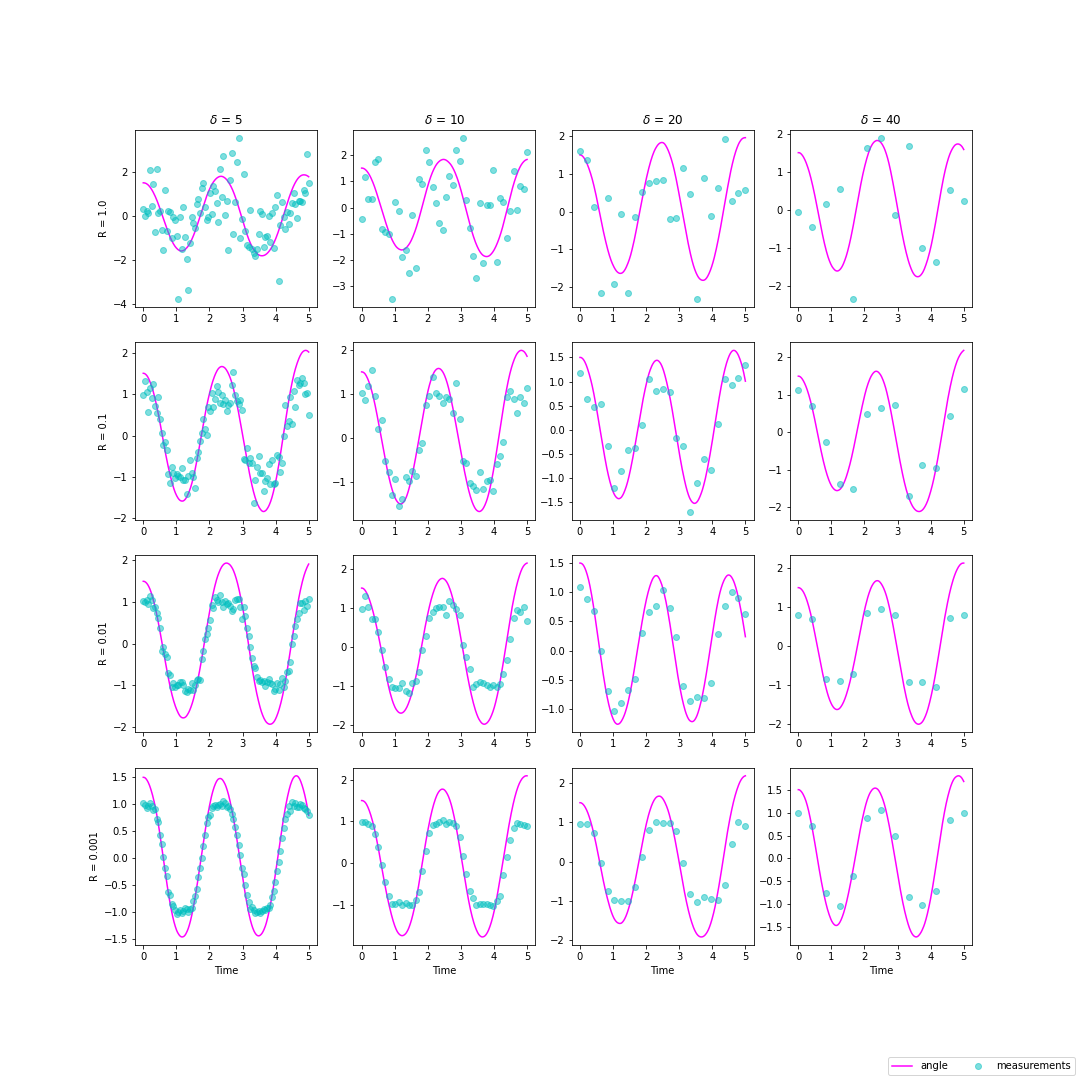

In [149]:
deltat = 0.01
x0 = np.array([[1.5,0]])

qc = 0.1
Q = np.array([[(qc*deltat**3)/3 , (qc*deltat**2)/2 ],
              [(qc*deltat**2)/2 ,  qc*deltat]])
N = 500
deltaArray = np.array([5,10,20,40])
RArray = np.array([1, 0.1, 0.01, 0.001]) 


xoutStore = np.zeros((N+1, 2*np.size(deltaArray)*np.size(RArray)))
youtStore = np.zeros((np.round_(int(N/deltaArray[0])),np.size(deltaArray)*np.size(RArray)))
deltaInfo = np.zeros(np.size(deltaArray)*np.size(RArray))
RInfo = np.zeros(np.size(deltaArray)*np.size(RArray))
# k= 0
                     
                    
fig, sp = plt.subplots(4,4,figsize=(15,15))                    
for i in range(np.size(deltaArray)):
    delta = deltaArray[i]
    RInfoj = np.zeros(np.size(RArray))
    deltaInfoj = np.zeros(np.size(RArray))
    xoutStorej = np.zeros((N+1, 2*np.size(RArray)))
#     youtStorej  = np.zeros((np.round_(int(N/delta)),np.size(RArray)))
    youtStorej  = np.zeros((int(np.ceil((N/delta))),np.size(RArray)))

    for j in range(np.size(RArray)):
        R = RArray[j]
        RInfoj[j]=R
        deltaInfoj[j]=delta 
        xout, yout = pendulum(N, x0, deltat, delta, R, g=9.8)
        xoutStorej[:,j*xout.shape[1]:(j+1)*xout.shape[1]] = xout  
        youtStorej[:,j] = yout
#         print(yout.shape)

        T = N*deltat
        t = np.linspace(0, T, N+1)
        ty = np.linspace(0, T, int(np.ceil((N/delta))))
        sp[j,i].plot(t, xout[:, 0], color='magenta', label='angle')
        sp[j,i].plot(ty, yout, 'co', alpha=0.5, label='measurements')
        
        
        
        
        
#         k=k+1
        if i == 0:
#             sp[j,i].set_ylabel('State Estimate with R = ' +str(R),fontsize=10)
            sp[j,i].set_ylabel('R = ' +str(R),fontsize=10)
        if j == (np.size(deltaArray)-1) :
            sp[j,i].set_xlabel('Time', fontsize=10)
#             sp[j,i].set_xlabel(''+str(delta)+'Time', fontsize=10)
        if j == 0:
            sp[j,i].set_title('$\delta$ = ' +str(delta))
        
    deltaInfo[i*np.size(deltaInfoj):(i+1)*np.size(deltaInfoj)] = deltaInfoj
    RInfo[i*np.size(RInfoj):(i+1)*np.size(RInfoj)] = RInfoj
    xoutStore[:,i*xoutStorej.shape[1]:(i+1)*xoutStorej.shape[1]] = xoutStorej
    youtStore[0:youtStorej.shape[0],i*youtStorej.shape[1]:(i+1)*youtStorej.shape[1]] = youtStorej

sp[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)  

# print(deltaInfo)
# print(RInfo)

# fig.suptitle('Identifiable Version',fontsize=12)
# plt.show


# T = N*deltat
# t = np.linspace(0, T, N+1)
# ty = np.linspace(0, T, int(N/delta))
# plt.figure()
# plt.plot(t, xout[:, 0], color='magenta', label='angle')
# plt.plot(ty, yout, 'co', alpha=0.5, label='measurements')
# plt.legend()
# plt.xlabel('Time', fontsize=14)
# plt.ylabel('State Estimate',fontsize=14)
# plt.show()

In [118]:
# PLOT 


NameError: name 'figsize' is not defined

In [116]:
(np.size(deltaArray)-1)

3

In [ ]:
# KF

In [151]:
def linear_prediction_step(A, mean, cov, sigma, deltat):
    """Linear Prediction Step: Propagate uncertainty for one time step

    X_{k+1} = A X_{k} + xi, xi sim mathcal{N}{0, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    A: (d, d) linear matrix
    mean: (d, ) prior mean
    cov: (d, d) prior covariance, symmetric positive definite
    sigma (noise_cov): (d, d) process noise covariance, symmetric positive definite

    Returns
    -------
    pred_mean: (d, ) predicted mean phi(m_{k-1})
    pred_cov: (d, d) predicted covariance (ACA^T+Sigma)
    """

    pred_mean = np.array([[(mean[0] + mean[1]*deltat)],
                          [(mean[1] - g*np.sin(mean[0])*deltat)]])
    

    pred_cov = np.dot(A, np.dot(cov, A.T)) + sigma
    
    return pred_mean, pred_cov

In [152]:
def linear_update_step(data, H, mean, cov, gamma):
    """Linear Gaussian Inverse Problem
    
    Inputs
    ------
    data: (N) array of data
    H for us (A): (N, d) linear model
    mean: (d) prior mean
    cov: (d, d) prior covariance
    noise_cov : (N, N) noise covariance matrix
    
    Returns
    -------
    update_mean: (d, ) updated mean
    update_cov: (d, d) updated covariance
    
    """
#     mean = mean.T
    mu =  np.sin(mean[0])
    delta = data - mu
    S = np.dot(H, np.dot(cov, H.T)) + gamma
    U = np.dot(cov, H.T)
    
    USinv = U/S
#     USinv = np.dot(U, (1/S))
#     print(mean.shape)
#     print(USinv.shape)  
#     update_mean = mean + np.dot(USinv, delta)
    update_mean = mean + USinv*delta
    update_cov = cov - np.dot(USinv, U.T)
#     print((USinv*delta).shape)
#     print(update_mean.shape)
#     print(update_cov.shape)
#     update_mean = update_mean.T

#     USinv = np.dot(U, np.linalg.inv(S))
#     update_mean = mean + np.dot(USinv, delta)
#     update_cov = cov - np.dot(USinv, U.T)   
      
#     update_mean = mean + np.dot(U, np.linalg.solve(S, delta))
#     update_cov = cov - np.dot(U, np.linalg.solve(S, U.T))

    update_mean = update_mean.squeeze()
    return update_mean, update_cov

In [154]:
def kalman_filter(N,data, proc_cov, meas_cov, prior_mean, prior_cov, deltat, delta):
    """The Kalman filter
    
    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    A: (d, d), dynamics 
    proc_cov: (d,d), process noise covariance
    H: (m, d), observation operator
    meas_cov: (m, m), measurement noise covariance
    prior_mean: (d, ) prior mean
    prior_cov: (d, d), prior_covariance
    
    Return
    ------
    mean_store: (N+1, d): posterior means (first row is the prior)
    cov_store: (d, d, N+1): posterior covariances (first block is the prior)    
    """
    
#     print(prior_mean.shape)
    d = prior_mean.shape[0]
#     print(d)
#     N = data.shape[0]
#     m = data.shape[1]
    
    mean_store = np.zeros((d,N+1))
#     print(d)
#     print(N+1)
#     print(mean_store.shape)
#     mean_store[:,0] = np.copy(prior_mean)
    mean_store[:,0] = np.copy((prior_mean).squeeze())
#     print(mean_store)
#     print(mean_store.shape)
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    
    #Loop over all data
    for ii in range(N):
        
        mean_ii = np.reshape(mean_store[:,ii], (2, 1))
#         print(mean_ii)
        
        # update A
        
        A = np.array([[1, deltat], [-g*deltat*np.cos(mean_store[0,ii]), 1]])
        
        # Prediction
        
        pred_mean, pred_cov = linear_prediction_step(A, mean_ii, cov_store[:, :, ii], proc_cov, deltat)

        pred_mean = np.reshape(pred_mean,(2,1))
        
#         print(pred_mean)
#         print(pred_mean.shape)
        
        # update H
        
        H = np.array([[np.cos(int(pred_mean[0,:])), 0]])
#         print(pred_mean[0,:])
        
        # Update if measurement is available
        if ii%delta == 0:
        
            mean_store[:,ii+1], cov_store[:, :, ii+1] = linear_update_step(data[int(ii/delta)], H, pred_mean, pred_cov, meas_cov)
        
        else:
        
            mean_store[:,ii+1]   = pred_mean.squeeze()
            cov_store[:, :, ii+1] = pred_cov
        
    return mean_store, cov_store

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
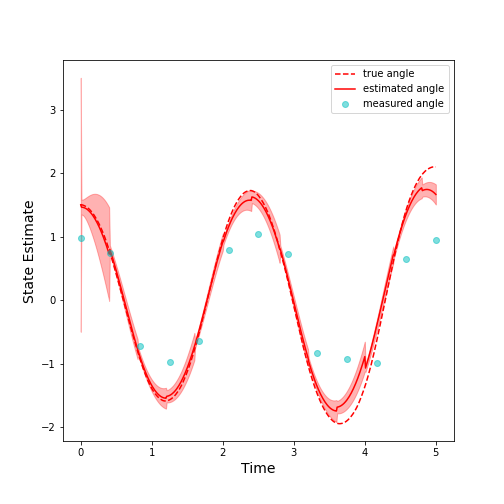

In [159]:
def get_std(cov):
    """Get square root of diagonals (standard deviations) from covariances """
    
    d, d, N = cov.shape
    std_devs = np.zeros((N, d))
    for ii in range(N):
        std_devs[ii, :] = np.sqrt(np.diag(cov[:, :, ii]))
    return std_devs

std_devs = get_std(covpost) #extract the standard deviations at all the states
plt.figure(figsize=(7,7))
plt.plot(t, xout[:, 0],'--', color='red', label='true angle')
# plt.plot(t, xout[:, 1],'--', color='blue', label='state1truth')

plt.plot(t, meanpost[0,:], color='red', label='estimated angle')
# plt.plot(t, meanpost[:, 1], color='blue', label='state1')
plt.fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
                color='red', alpha=0.3)
# plt.fill_between(t, meanpost[:, 1] - 2 * std_devs[:, 1],  meanpost[:, 1] + 2*std_devs[:, 1],
#                 color='blue', alpha=0.3)
#plt.plot(t[1:], yout[:, 0], 'ko', alpha=0.4)
#plt.plot(t[1:], yout[:, 1], 'kx', alpha=0.4)
plt.plot(ty, yuse, 'co', alpha=0.5, label='measured angle')
# plt.plot(t[1:], yuse[:, 1], 'kx', alpha=0.4)
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('State Estimate',fontsize=14)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
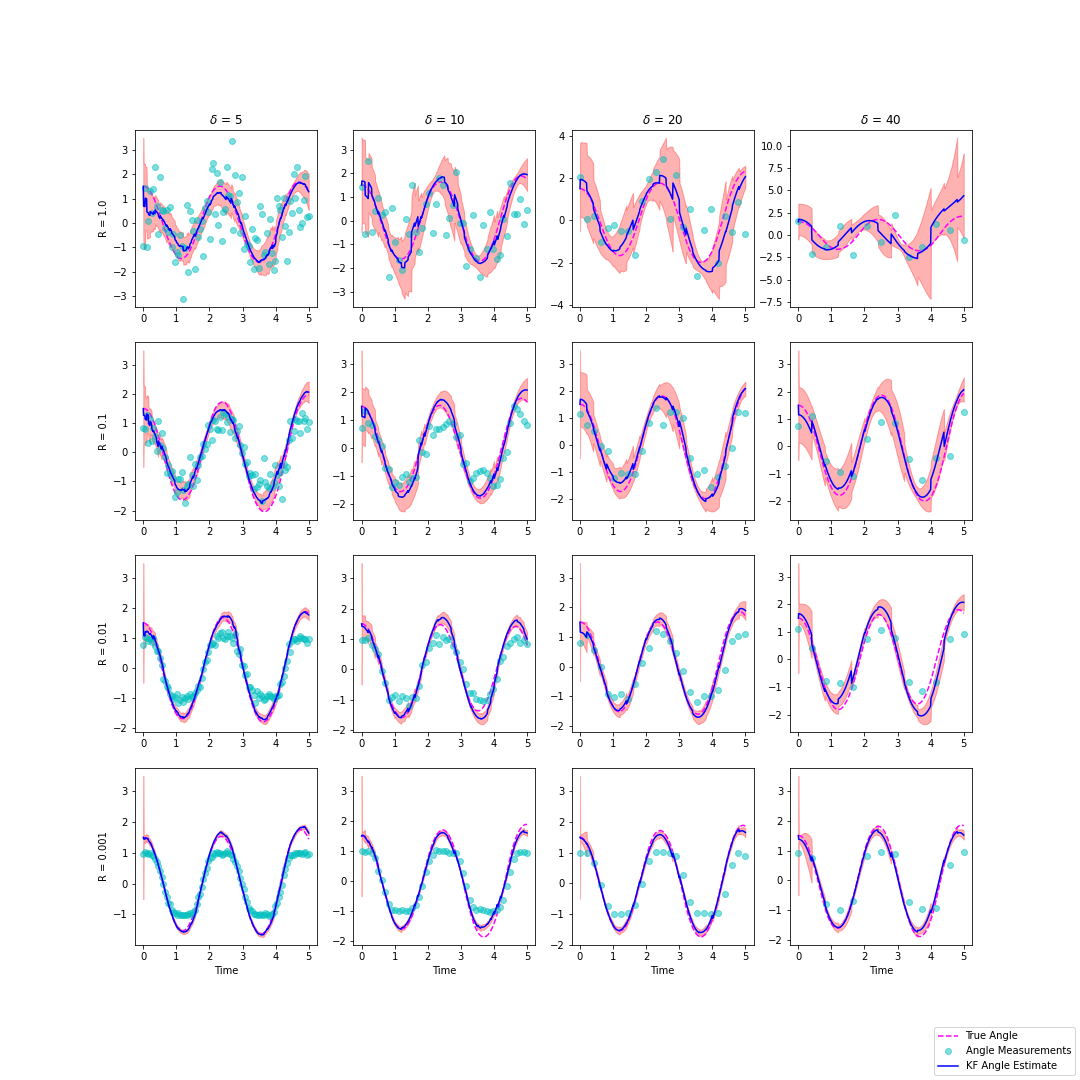

In [162]:
g=9.81

xoutStore = np.zeros((N+1, 2*np.size(deltaArray)*np.size(RArray)))
youtStore = np.zeros((np.round_(int(N/deltaArray[0])),np.size(deltaArray)*np.size(RArray)))
deltaInfo = np.zeros(np.size(deltaArray)*np.size(RArray))
RInfo = np.zeros(np.size(deltaArray)*np.size(RArray))
# k= 0
                     
                    
fig, sp = plt.subplots(4,4,figsize=(15,15))                    
for i in range(np.size(deltaArray)):
    delta = deltaArray[i]
    RInfoj = np.zeros(np.size(RArray))
    deltaInfoj = np.zeros(np.size(RArray))
    xoutStorej = np.zeros((N+1, 2*np.size(RArray)))
#     youtStorej  = np.zeros((np.round_(int(N/delta)),np.size(RArray)))
    youtStorej  = np.zeros((int(np.ceil((N/delta))),np.size(RArray)))

    for j in range(np.size(RArray)):
        R = RArray[j]
        RInfoj[j]=R
        deltaInfoj[j]=delta 
        xout, yout = pendulum(N, x0, deltat, delta, R, g=9.8)
        xoutStorej[:,j*xout.shape[1]:(j+1)*xout.shape[1]] = xout  
        youtStorej[:,j] = yout
#         print(yout.shape)
        yuse = yout


        # prior_mean = np.zeros((2)) # prior mean
        prior_mean = x0.T # prior mean
        prior_cov = np.eye(2)  # prior covariance
        proc_cov = Q # 1e-1 * np.eye(2) # process noise covariance
        meas_cov = R # 1e-1 * np.eye(H.shape[0]) #measurement noise covariance
        meanpost, covpost = kalman_filter(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, deltat, delta)
        std_devs = get_std(covpost) #extract the standard deviations at all the states
        
        T = N*deltat
        t = np.linspace(0, T, N+1)
        ty = np.linspace(0, T, int(np.ceil((N/delta))))
        sp[j,i].plot(t, xout[:, 0],'--', color='magenta', label='True Angle')
        sp[j,i].plot(ty, yout, 'co', alpha=0.5, label='Angle Measurements')
        sp[j,i].plot(t, meanpost[0,:], color='blue', label='KF Angle Estimate')
        sp[j,i].fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
                color='red', alpha=0.3)


        
        
        
        
        
#         k=k+1
        if i == 0:
#             sp[j,i].set_ylabel('State Estimate with R = ' +str(R),fontsize=10)
            sp[j,i].set_ylabel('R = ' +str(R),fontsize=10)
        if j == (np.size(deltaArray)-1) :
            sp[j,i].set_xlabel('Time', fontsize=10)
#             sp[j,i].set_xlabel(''+str(delta)+'Time', fontsize=10)
        if j == 0:
            sp[j,i].set_title('$\delta$ = ' +str(delta))
        
    deltaInfo[i*np.size(deltaInfoj):(i+1)*np.size(deltaInfoj)] = deltaInfoj
    RInfo[i*np.size(RInfoj):(i+1)*np.size(RInfoj)] = RInfoj
    xoutStore[:,i*xoutStorej.shape[1]:(i+1)*xoutStorej.shape[1]] = xoutStorej
    youtStore[0:youtStorej.shape[0],i*youtStorej.shape[1]:(i+1)*youtStorej.shape[1]] = youtStorej

sp[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=1)  

In [ ]:
yuse = yout
g=9.81

# prior_mean = np.zeros((2)) # prior mean
prior_mean = x0.T # prior mean
prior_cov = np.eye(2)  # prior covariance
proc_cov = Q # 1e-1 * np.eye(2) # process noise covariance
meas_cov = R # 1e-1 * np.eye(H.shape[0]) #measurement noise covariance
meanpost, covpost = kalman_filter(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, deltat, delta)

In [ ]:
t.shape

In [ ]:
T = N*deltat
t = np.linspace(0, T, N+1)
ty = np.linspace(0, T, int(N/delta))
plt.figure()
plt.plot(t, xout[:, 0], color='magenta', label='angle')
plt.plot(ty, yout, 'co', alpha=0.5, label='measurements')
plt.plot(t, meanpost[0,:], color='blue', label='kf angle')
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('State Estimate',fontsize=14)
plt.show()

In [ ]:
def get_std(cov):
    """Get square root of diagonals (standard deviations) from covariances """
    
    d, d, N = cov.shape
    std_devs = np.zeros((N, d))
    for ii in range(N):
        std_devs[ii, :] = np.sqrt(np.diag(cov[:, :, ii]))
    return std_devs

std_devs = get_std(covpost) #extract the standard deviations at all the states
plt.figure(figsize=(7,7))
plt.plot(t, xout[:, 0],'--', color='red', label='true angle')
# plt.plot(t, xout[:, 1],'--', color='blue', label='state1truth')

plt.plot(t, meanpost[0,:], color='red', label='estimated angle')
# plt.plot(t, meanpost[:, 1], color='blue', label='state1')
plt.fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
                color='red', alpha=0.3)
# plt.fill_between(t, meanpost[:, 1] - 2 * std_devs[:, 1],  meanpost[:, 1] + 2*std_devs[:, 1],
#                 color='blue', alpha=0.3)
#plt.plot(t[1:], yout[:, 0], 'ko', alpha=0.4)
#plt.plot(t[1:], yout[:, 1], 'kx', alpha=0.4)
plt.plot(ty, yuse, 'co', alpha=0.5, label='measured angle')
# plt.plot(t[1:], yuse[:, 1], 'kx', alpha=0.4)
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('State Estimate',fontsize=14)
plt.show()

In [ ]:
std_devs = get_std(covpost) #extract the standard deviations at all the states
plt.figure(figsize=(7,7))
plt.plot(t, xout[:, 0],'--', color='red', label='true angle')
plt.plot(t, xout[:, 1],'--', color='blue', label='true angular rate')

plt.plot(t, meanpost[0,:], color='red', label='estimated angle')
plt.plot(t, meanpost[1,:], color='blue', label='estimated angular rate')
plt.fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
                color='red', alpha=0.3)
plt.fill_between(t, meanpost[1,:] - 2 * std_devs[:, 1],  meanpost[1,:] + 2*std_devs[:, 1],
                color='blue', alpha=0.3)
#plt.plot(t[1:], yout[:, 0], 'ko', alpha=0.4)
#plt.plot(t[1:], yout[:, 1], 'kx', alpha=0.4)
plt.plot(ty, yuse, 'co', alpha=0.5, label='measured angle')
# plt.plot(t[1:], yuse[:, 1], 'kx', alpha=0.4)
plt.legend()
plt.xlabel('Time', fontsize=14)
plt.ylabel('State Estimate',fontsize=14)
plt.show()

In [ ]:
fig, sp = plt.subplots(4,1,figsize(8,7))
sp[0].plot(sol.t,sol.y[0,:],label='Susceptible')
sp[0].set_ylabel('Susceptible')
sp[0].set_xlabel('Time')
sp[1].plot(sol.t,sol.y[1,:],label='Infected')
sp[1].set_ylabel('Infected')
sp[1].set_xlabel('Time')
sp[2].plot(sol.t,sol.y[1,:],label='Recovered')
sp[2].set_ylabel('Recovered')
sp[2].set_xlabel('Time')
sp[3].plot(sol.t,sol.y[0,:],label='Susceptible')
sp[3].plot(sol.t,sol.y[1,:],label='Infected')
sp[3].plot(sol.t,sol.y[1,:],label='Recovered')
sp[3].legend()
sp[3].set_ylabel('Portions of the Population')
fig.suptitle('Identifiable Version',fontsize=12)
plt.sho

In [ ]:
## UKF

In [ ]:

def nonlinphi(x):
    g = 9.81
    N = x.shape[0]
    out = np.zeros((x.shape[0], 2))
#     print(out.shape)
#     print(x.shape)
    out[:, 0] = x[:,0] + x[:,1]*deltat
    out[:, 1] = x[:,1] - g*np.sin(x[:,0])*deltat
    
    return out

def nonlinh(x):
    N = x.shape[0]
    out = np.zeros((x.shape[0], 1))
    out[:, 0] = np.sin(x[:,0]) 
    return out

In [ ]:
def plot_points(N, cov, func, tpoints):
    """Plot a Gaussian and a Transformed Variable
    
    Inputs
    ------
    N: number of samples
    cov: covariance of the gaussian
    func: nonlinear function to visualize
    tpoints: (N, 2) array of any special input points we might want to see transformed    
    
    Returns
    -------
    fig, axs, tpt
    tpt is (N, 2) array of transformed points or none if tpoints is None
    """
    
    # Sample from the Gaussian (mean 0)
    L = np.linalg.cholesky(cov)
    x = np.dot(L, np.random.randn(2, N)).T

    # Plot the "original" points
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(x[:, 0], x[:, 1], 'o', ms=1)
    #axs[0].plot(0, 0, 'o', color='black', ms=10)
    if tpoints is not None:
        axs[0].plot(tpoints[:, 0], tpoints[:, 1], 'go', ms=10)
    axs[0].set_title("Original", fontsize=14)
    axs[0].set_xlabel(r'$X_1$', fontsize=14)
    axs[0].set_ylabel(r'$X_2$', fontsize=14)
    
    xt = func(x)
    print(xt.shape)
    axs[1].plot(xt[:, 0], xt[:, 1], 'ro', ms=1)
    #mt = np.mean(xt, axis=0)
    #axs[1].plot(mt[0], mt[1], 'o', color='black', ms=10)

    tpt = None
    if tpoints is not None:
        tpt = func(tpoints)
        axs[1].plot(tpt[:, 0], tpt[:, 1], 'go', ms=10)
    axs[1].set_title("Transformed", fontsize=14)
    axs[1].set_xlabel(r'$Y_1$', fontsize=14)
    axs[1].set_ylabel(r'$Y_2$', fontsize=14)
    
    return fig, axs, tpt

In [ ]:
fig, axs, _ = plot_points(1000,Q, nonlinphi, None)

In [ ]:
def unscented_points(mean, cov, alg='chol', alpha=1, beta=0, kappa=0):
    """Generate unscented points"""    
    dim = cov.shape[0]
    lam = alpha*alpha*(dim + kappa) - dim
    if alg == "chol":
        L = np.linalg.cholesky(cov)
    elif alg == "svd":
        u, s, v = np.linalg.svd(cov)
        L = np.dot(u, np.sqrt(np.diag(s)))
        
    pts = np.zeros((2*dim+1, 2))
    pts[0, :] = mean
    
    for ii in range(1, dim+1):        
        pts[ii, :] = mean + np.sqrt(dim + lam)*L[:, ii-1]        
        pts[ii+dim,:] = mean - np.sqrt(dim + lam)*L[:, ii-1]

    W0m = lam / (dim + lam)
    W0C = lam / (dim + lam) + (1 - alpha*alpha + beta)
    Wim = 1/2 / (dim + lam)
    Wic = 1/2 / (dim + lam)
    return pts, (W0m, Wim, W0C, Wic)

In [ ]:
UP, w = unscented_points(np.zeros(2), reference_cov(), alg='chol')
fig, axs, tpts = plot_points(1000, reference_cov(), nonlin1, UP)

In [ ]:
def UKF_prediction_step(mean, cov, sigma, deltat):
    
    dimPre = cov.shape[0]
    
    UP, w = unscented_points(mean, cov, alg='chol') # returns pts, (W0m, Wim, W0C, Wic)
    dynamicsOutMean= nonlinphi(UP)
    
#     for ii in range(2*dimPre+1):
    
    

#     pred_mean = 
    
#     dynamicsOutCov = np.dot((nonlinphi(UP)- pred_mean),(nonlinphi(UP)- pred_mean).T))
    
#     covIntegralOut = ....
#     pred_cov = covIntegralOut + sigma
    
    return # pred_mean, pred_cov

In [ ]:
aa, bb = UKF_prediction_step(x0, Q, proc_cov, deltat)

In [ ]:
def UKF_update_step(data, mean, cov, gamma):
    
    
    
    
    UP, w = unscented_points(mean, cov, alg='chol') # returns pts, (W0m, Wim, W0C, Wic)
    dynamicsOutMean= nonlinh(UP)
    
    mu = .....
    delta = data - mu
    
    update_mean = mean + USinv*delta
    
    
    
    dynamicsOutCov = np.dot((nonlinh(UP)- update_mean),(nonlinh(UP)- update_mean).T)
    
    S = .....
    
    USinv = U/S
    update_cov = cov - np.dot(USinv, U.T)

#     mean = mean.T
    mu =  np.sin(mean[0])
    delta = data - mu
    S = np.dot(H, np.dot(cov, H.T)) + gamma
    U = np.dot(cov, H.T)
    
    

#     update_mean = mean + np.dot(USinv, delta)
    

#     update_mean = update_mean.T

#     USinv = np.dot(U, np.linalg.inv(S))
#     update_mean = mean + np.dot(USinv, delta)
#     update_cov = cov - np.dot(USinv, U.T)   
      
#     update_mean = mean + np.dot(U, np.linalg.solve(S, delta))
#     update_cov = cov - np.dot(U, np.linalg.solve(S, U.T))

    update_mean = update_mean.squeeze()
    return update_mean, update_cov

In [ ]:
def UKF(N,data, proc_cov, meas_cov, prior_mean, prior_cov, deltat, delta):
    """The Kalman filter
    
    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    A: (d, d), dynamics 
    proc_cov: (d,d), process noise covariance
    H: (m, d), observation operator
    meas_cov: (m, m), measurement noise covariance
    prior_mean: (d, ) prior mean
    prior_cov: (d, d), prior_covariance
    
    Return
    ------
    mean_store: (N+1, d): posterior means (first row is the prior)
    cov_store: (d, d, N+1): posterior covariances (first block is the prior)    
    """

    d = prior_mean.shape[0]
    mean_store = np.zeros((d,N+1))
    mean_store[:,0] = np.copy((prior_mean).squeeze())
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    
    #Loop over all data
    for ii in range(N):
        
        mean_ii = np.reshape(mean_store[:,ii], (2, 1))
        
        # update A
        
        A = np.array([[1, deltat], [-g*deltat*np.cos(mean_store[0,ii]), 1]])
        
        # Prediction
        
        pred_mean, pred_cov = linear_prediction_step(A, mean_ii, cov_store[:, :, ii], proc_cov, deltat)
        pred_mean = np.reshape(pred_mean,(2,1))

        # update H
        
        H = np.array([[np.cos(int(pred_mean[0,:])), 0]])

        # Update if measurement is available
        if ii%delta == 0:
            mean_store[:,ii+1], cov_store[:, :, ii+1] = linear_update_step(data[int(ii/delta)], H, pred_mean, pred_cov, meas_cov)
        else:
            mean_store[:,ii+1]   = pred_mean.squeeze()
            cov_store[:, :, ii+1] = pred_cov
        
    return mean_store, cov_store

In [ ]:
: colon, ; semicolon

In [ ]:
std_devs

In [ ]:
xout.shape


In [ ]:
print(x0)


In [ ]:
if ii%delta == 0
int(ii/delta)

In [ ]:
deltaArray = np.array([5,10,20,40])

In [ ]:
deltaArray[0]

In [ ]:
A = np.array([[1, deltat], [-g*np.cos(m_k_1), -0.5]])
H = np.array([[np.cos(mk_), 0]])

In [ ]:
np.random.randn(2,1)

In [ ]:
a = np.random.randn(2)
print(a)
qq = np.linalg.cholesky(Q)
print(qq)
np.dot(qq,a)

In [ ]:
x0.shape[1]

In [ ]:
delta


In [ ]:
fig, sp = plt.subplots(4,1,figsize(8,7))
sp[0].plot(sol.t,sol.y[0,:],label='Susceptible')
sp[0].set_ylabel('Susceptible')
sp[0].set_xlabel('Time')
sp[1].plot(sol.t,sol.y[1,:],label='Infected')
sp[1].set_ylabel('Infected')
sp[1].set_xlabel('Time')
sp[2].plot(sol.t,sol.y[1,:],label='Recovered')
sp[2].set_ylabel('Recovered')
sp[2].set_xlabel('Time')
sp[3].plot(sol.t,sol.y[0,:],label='Susceptible')
sp[3].plot(sol.t,sol.y[1,:],label='Infected')
sp[3].plot(sol.t,sol.y[1,:],label='Recovered')
sp[3].legend()
sp[3].set_ylabel('Portions of the Population')
fig.suptitle('Identifiable Version',fontsize=12)
plt.show